## 判斷是否使用Google colab執行
若是，則從Google Drive掛載資料，Google colab專用 否則應設定 ROOT_DIR

In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

print('IN_COLAB', IN_COLAB)

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/Shared drives/Straight A students/類神經網路/flowers'
else:
    ROOT_DIR = 'flowers'

IN_COLAB True
Mounted at /content/drive


## import

In [2]:
""" Deep Convolutional Generative Adversarial Network (DCGAN).

Using deep convolutional generative adversarial networks (DCGAN) to generate
digit images from a noise distribution.

References:
    - Unsupervised representation learning with deep convolutional generative
    adversarial networks. A Radford, L Metz, S Chintala. arXiv:1511.06434.

Links:
    - [DCGAN Paper](https://arxiv.org/abs/1511.06434).
    - [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## 設定參數

In [0]:
# Training Params
n_epoch = 50
batch_size = 128
image_size = 60

# Network Params
image_dim = image_size * image_size * 3
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 200 # Noise data points

## Read dataset

In [4]:
import torchvision
from torch.utils.data import DataLoader

flowers_dataset = torchvision.datasets.ImageFolder(
    ROOT_DIR,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor()
    ])
)
print(flowers_dataset)
train_loader = DataLoader(dataset = flowers_dataset, batch_size = batch_size, shuffle = True)

Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/Shared drives/Straight A students/類神經網路/flowers
    StandardTransform
Transform: Compose(
               Resize(size=(60, 60), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


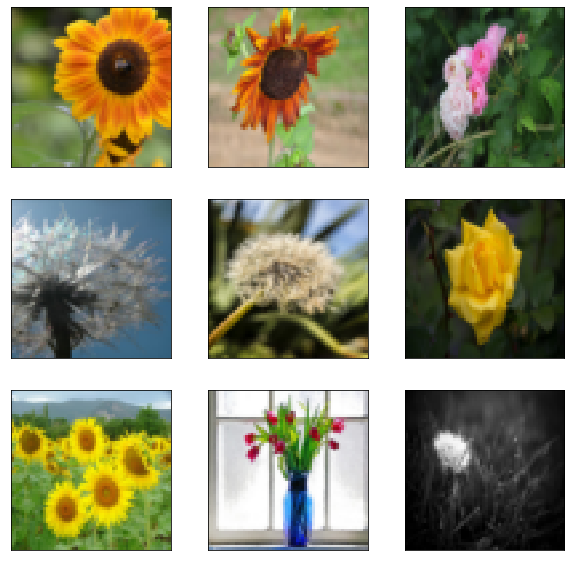

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].data.cpu().numpy().transpose(1,2,0), cmap=plt.cm.binary)
plt.show()

## 定義網路

In [0]:
# Generator Network
# Input: Noise, Output: Image
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=6 * 6 * 128)
        x = tf.nn.tanh(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        x = tf.reshape(x, shape=[-1, 6, 6, 128])
        x = tf.layers.conv2d_transpose(x, 64, 4, strides=2)
        x = tf.layers.conv2d_transpose(x, 6, 4, strides=2)
        x = tf.layers.conv2d_transpose(x, 3, 2, strides=2)
        # Apply sigmoid to clip values between 0 and 1
        x = tf.nn.sigmoid(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        # 60*60
        x = tf.layers.conv2d(x, 64, 5) # 56*56*64
        x = tf.nn.tanh(x)
        x = tf.layers.average_pooling2d(x, 2, 2) # 28*28*64
        x = tf.layers.conv2d(x, 128, 5) # 24*24*128
        x = tf.nn.tanh(x)
        x = tf.layers.average_pooling2d(x, 2, 2) # 12*12*128
        x = tf.layers.conv2d(x, 128, 5) # 8*8*128
        x = tf.nn.tanh(x)
        x = tf.layers.average_pooling2d(x, 2, 2) # 4*4*128
        x = tf.contrib.layers.flatten(x) # 4*4*128=2048
        x = tf.layers.dense(x, 1024)
        x = tf.nn.tanh(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

In [7]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3])

# Build Generator Network
gen_sample = generator(noise_input)
print(gen_sample)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
print(disc_real)
disc_fake = discriminator(gen_sample, reuse=True)
disc_concat = tf.concat([disc_real, disc_fake], axis=0)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Targets (real or fake images)
disc_target = tf.placeholder(tf.int32, shape=[None])
gen_target = tf.placeholder(tf.int32, shape=[None])

# Build Loss
disc_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_concat, labels=disc_target))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=gen_target))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.001)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=0.001)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Tensor("Generator/Sigmoid:0", shape=(?, 60, 60, 3), dtype=float32)
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Tensor("Discriminator/dense_1/BiasAdd:0", shape=(?, 2), dtype=float32)


## 訓練

In [0]:
# Start training
sess = tf.Session()

# Run the initializer
sess.run(init)

In [9]:
for i in range(1, n_epoch+1):
    j = 0
    for batch_x, label in train_loader:
        j += 1
        temp_batch_size = batch_x.shape[0]

        batch_x = np.reshape(batch_x, newshape=[-1, image_size, image_size, 3])
        # Generate noise to feed to the generator
        z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

        # Prepare Targets (Real image: 1, Fake image: 0)
        # The first half of data fed to the generator are real images,
        # the other half are fake images (coming from the generator).
        batch_disc_y = np.concatenate(
            [np.ones([temp_batch_size]), np.zeros([batch_size])], axis=0)
        # Generator tries to fool the discriminator, thus targets are 1.
        batch_gen_y = np.ones([batch_size])

        # print(batch_x.shape, z.shape, batch_disc_y.shape, batch_gen_y.shape)
        # Training
        feed_dict = {real_image_input: batch_x, noise_input: z,
                        disc_target: batch_disc_y, gen_target: batch_gen_y}
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                feed_dict=feed_dict)

        print('epoch %i-%i: Generator Loss: %f, Discriminator Loss: %f' % (i, j, gl, dl))

epoch 1-1: Generator Loss: 0.652208, Discriminator Loss: 0.690655
epoch 1-2: Generator Loss: 11.767344, Discriminator Loss: 4.710199
epoch 1-3: Generator Loss: 0.000000, Discriminator Loss: 15.989039
epoch 1-4: Generator Loss: 4.887054, Discriminator Loss: 1.970715
epoch 1-5: Generator Loss: 0.000002, Discriminator Loss: 6.540310
epoch 1-6: Generator Loss: 0.035823, Discriminator Loss: 1.697066
epoch 1-7: Generator Loss: 13.773416, Discriminator Loss: 5.910552
epoch 1-8: Generator Loss: 15.025276, Discriminator Loss: 6.539845
epoch 1-9: Generator Loss: 7.087035, Discriminator Loss: 2.824510
epoch 1-10: Generator Loss: 0.000959, Discriminator Loss: 3.479677
epoch 1-11: Generator Loss: 0.016320, Discriminator Loss: 2.075722
epoch 1-12: Generator Loss: 2.336650, Discriminator Loss: 1.016371
epoch 1-13: Generator Loss: 4.981611, Discriminator Loss: 1.912182
epoch 1-14: Generator Loss: 2.244294, Discriminator Loss: 0.935456
epoch 1-15: Generator Loss: 0.010759, Discriminator Loss: 2.278412


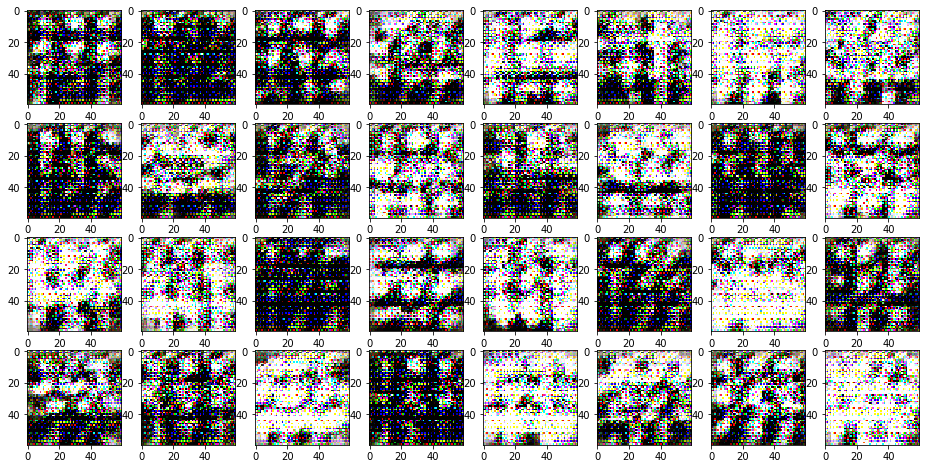

In [10]:
# Generate images from noise, using the generator network.
f, a = plt.subplots(4, 8, figsize=(16, 8))
for i in range(8):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[4, noise_dim])
    # z = np.random.random_sample(size=[4, noise_dim])*2-1
    g = sess.run(gen_sample, feed_dict={noise_input: z})
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        img = np.reshape(g[j][:, :, np.newaxis],
                            newshape=(image_size, image_size, 3))
        a[j][i].imshow(img)

f.show()
plt.draw()